In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

# define geometry
cav_geom = pd.read_csv('geodata.n', 
                       header=None, skiprows=3, skipfooter=1, sep='\s+', engine='python')[[1, 0]]

pnts = list(cav_geom.itertuples(index=False, name=None))

wp = WorkPlane()
wp.MoveTo(*pnts[0])
for p in pnts[1:]:
  wp.LineTo(*p)
wp.Close().Reverse()
face = wp.Face()

# name the boundaries
face.edges.Max(X).name =  "r"
face.edges.Max(X).col = (1,0,0)
face.edges.Min(X).name = "l"
face.edges.Min(X).col = (1,0,0)
face.edges.Min(Y).name = "b"
face.edges.Min(Y).col = (1,0,0)

geo = OCCGeometry(face, dim=2)

ngmesh = geo.GenerateMesh(maxh=0.1)
mesh = Mesh(ngmesh)

n = specialcf.normal(mesh.dim)
nt = specialcf.tangential(mesh.dim)
h = specialcf.mesh_size
dS = dx(element_boundary=True)

def tang(vec):
    return vec - (vec*n)*n

Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [2]:
# fes = HCurl(mesh, order=1, dirichlet='default')
fes = HCurl(mesh, order=1, dirichlet='l|b|r')
# fes = HCurl(mesh, order=1)
# print(fes.FreeDofs())
# Create a coefficient function for the Dirichlet boundary condition
# g = (10, 10)
# gfu = GridFunction(fes)
# gfu.Set(g, BND)
# Draw(gfu);

mu0 = 4*pi*1e-7
c0 = 299792458
u, v = fes.TnT()

a = BilinearForm((1/y * Grad(u)[1]*Grad(v)[1] + y*Grad(u)[0]*Grad(v)[0])*dx)
m = BilinearForm(1/y * u*v*dx)

apre = BilinearForm((1/y * Grad(u)[1]*Grad(v)[1] + Grad(u)[0]*Grad(v)[0])*dx + 1/y*u*v*dx).Assemble()
pre = Preconditioner(apre, "direct", inverse="sparsecholesky")

(23410, 23410)


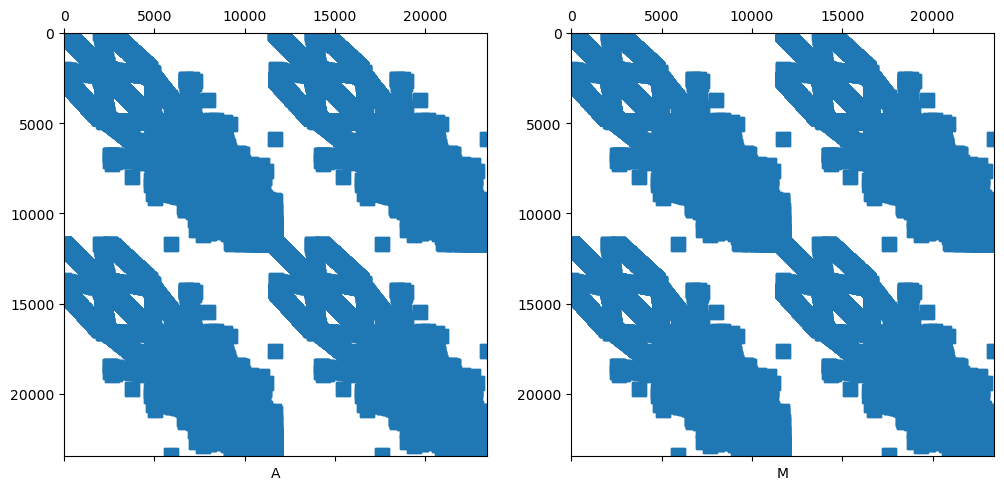

In [30]:
# with scipy
a.Assemble()
m.Assemble()
freedofs = fes.FreeDofs()


A = scipy.sparse.csr_matrix(a.mat.CSR())
M = scipy.sparse.csr_matrix(m.mat.CSR())
print(np.shape(A))

plt.rcParams['figure.figsize'] = (12, 12)
fig = plt.figure(); ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.set_xlabel("A"); ax1.spy(A)
ax2.set_xlabel("M"); ax2.spy(M)
plt.show()


In [13]:


# with scipy
rows,cols,vals = a.mat.COO()
A = scipy.sparse.csr_matrix((vals,(rows,cols)))
rows,cols,vals = m.mat.COO()
M = scipy.sparse.csr_matrix((vals,(rows,cols)))

evls, evecs = scipy.sparse.linalg.eigs(A, M=M, k=50, sigma=0.1, which='LM', maxiter=500, tol=1e-4)
# evls, evecs = ispm_iteration(a.mat.COO(), 4, 2, M=m.mat.COO())

AttributeError: 'NoneType' object has no attribute 'mat'

In [ ]:
with TaskManager():
    a.Assemble()
    m.Assemble()
    apre.Assemble()
    freedof_matrix = a.mat.CreateSmoother(fes.FreeDofs())

    # build gradient matrix as sparse matrix (and corresponding scalar FESpace)
    gradmat, fesh1 = fes.CreateGradient()

    gradmattrans = gradmat.CreateTranspose() # transpose sparse matrix
    math1 = gradmattrans @ m.mat @ gradmat   # multiply matrices
    math1[0, 0] += 1     # fix the 1-dim kernel
    invh1 = math1.Inverse(inverse="sparsecholesky")

    # build the Poisson projector with operator Algebra:
    proj = IdentityMatrix() - gradmat @ invh1 @ gradmattrans @ m.mat

    projpre = proj @ pre.mat
    evals, evecs = solvers.PINVIT(a.mat, m.mat, pre=projpre, num=30, maxit=20, printrates=False);

In [ ]:
apre.Assemble()

# build gradient matrix as sparse matrix (and corresponding scalar FESpace)
gradmat, fesh1 = fes.CreateGradient()

gradmattrans = gradmat.CreateTranspose() # transpose sparse matrix
math1 = gradmattrans @ m.mat @ gradmat   # multiply matrices
math1[0, 0] += 1     # fix the 1-dim kernel
invh1 = math1.Inverse(inverse="sparsecholesky")

# build the Poisson projector with operator Algebra:
proj = IdentityMatrix() - gradmat @ invh1 @ gradmattrans @ m.mat

projpre = proj @ pre.mat

g = (0, 0)
num = 5
u = GridFunction(fes, multidim=5)
u.Set(g, BND)

uvecs = MultiVector(u.vec, num)
vecs = MultiVector(u.vec, 2*num)

for v in vecs[0:num]:
    v.SetRandom()
uvecs[:] = pre * vecs[0:num]
lams = Vector(num * [1])

for i in range(20):
    vecs[0:num] = a.mat * uvecs - (m.mat * uvecs).Scale (lams)
    vecs[num:2*num] = pre * vecs[0:num]
    vecs[0:num] = uvecs

    vecs.Orthogonalize() # m.mat)

    asmall = InnerProduct (vecs, a.mat*vecs)
    msmall = InnerProduct (vecs, m.mat*vecs)

    ev,evec = scipy.linalg.eigh(a=asmall, b=msmall)
    lams = Vector(ev[0:num])
#     print (i, ":", [l/pi**2 for l in lams])

    uvecs[:] = vecs * Matrix(evec[:,0:num])

In [ ]:
print ("Eigenvalues")
freq_fes = []
for lam in lams:
    freq_fes.append(c0*np.sqrt(lam)/(2*np.pi) * 1e-6)
    print (lam, 'freq: ', c0*np.sqrt(lam)/(2*np.pi) * 1e-6, "MHz")

In [ ]:
print ('freq: ', [c0*np.sqrt(evl)/(2*np.pi) * 1e-6 for evl in lams], "MHz")
Draw (Norm(u.MDComponent(3)[0]), mesh, order=2);